In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.ndimage import rotate

from Xana import Xana
from Xana import CorrFunc

import sys
sys.path.insert(0, '../06-scripts/')
import xana_tools as xt

In [2]:
!pwd

/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/01-notebooks


In [3]:
!ls ../

01-notebooks  05-analysis	    05-analysis-powders        08-slurming
02-sources    05-analysis-02	    05-analysis-powders-tests  09-plots
03-masks      05-analysis-fluences  06-scripts		       results_xpcs
04-setups     05-analysis-phis	    07-analysis-waxs


# Functions

In [4]:
def fit(function,x,y,p0=None,sigma=None,bounds=[None,None],xc_len=False):
    '''
    fits a function and return the fit resulting parameters and curve
    '''
    popt,pcov = curve_fit(function,x,y,p0=p0,sigma=sigma,bounds=bounds)
    if xc_len: xc = np.linspace(min(x),max(x),100)
    else: xc = np.linspace(min(x),max(x),len(x))
    curve = function(xc,*popt)
    perr = np.sqrt(np.diag(pcov))
    return popt,xc,curve,perr

def exponential(x,a,b,c,d):
    return a*np.exp(-x**d/b)+c

In [5]:
def svd_(ttc, plot=False):
    
    #subtract baseline
    bl = np.mean(ttc[-100:,:100])
    ttc = ttc - bl +1
    
    # rotate img
    img = rotate(ttc, angle=-45)
    # fill in with zeros
    img[img==0.]=1.
    
    img2 = img[600:2200,1400:]
    
    # normalise
    img3 = (img2-img2.mean())/img2.std()
    
    # Perform SVD using np.linalg.svd
    U, s, V = np.linalg.svd(img3)
    
    # Compute Variance explained by each singular vector
    var_explained = np.round(s**2/np.sum(s**2), decimals=3)
    
    
    # first component
    num = 1
    e1 = np.matrix(U[:, :num]) * np.diag(s[:num]) * np.matrix(V[:num, :])
    # second component
    num = 2
    e2 = np.matrix(U[:, :num]) * np.diag(s[:num]) * np.matrix(V[:num, :])
    e2 = e2 - e1 
    # third component
    #num = 3
    #e3 = np.matrix(U[:, :num]) * np.diag(s[:num]) * np.matrix(V[:num, :])
    #e3 = e3 - e2 - e1 

    e12 = e1+e2
    
    e12_norm = np.zeros(e12.shape)
    # normalise
    for i in range(0,1600):
        e12_norm[i] = np.array(e12)[i]
        e12_norm[i] -= e12_norm[i][-1]
        e12_norm[i] /= e12_norm[i][0]
        
    #chi_0 = np.asarray(np.var(img2[300:800],axis=0)).squeeze()
    # calculate variance of e2
    chi = np.asarray(np.var(e12_norm[300:800],axis=0)).squeeze()
    
    if plot:
    
        plt.figure(figsize=(4,3.5))
        plt.plot(chi,c='black',alpha=0.3,lw=1)

        # logarithmic rebinning
        t_lin = np.linspace(0,len(chi),len(chi))
        t_log = np.logspace(0, 3.1, num=100)
        f = interp1d(t_lin, chi)
        plt.plot(t_log,gaussian_filter(f(t_log),sigma=2),c='red',lw=2)
        #plt.ylim(-0.001,0.005)
        plt.xlim(1e1, 1e3)
        plt.xscale('log')
        plt.ylabel(r'$\chi_T$')

        plt.tight_layout()
        plt.show()
        
    return chi


def svd_img(ttc, plot=False):
    
    #subtract baseline
    bl = np.mean(ttc[-100:,:100])
    ttc = ttc - bl +1
    
    # rotate img
    img = rotate(ttc, angle=-45)
    # fill in with zeros
    img[img==0.]=1.
    
    img2 = img[600:2200,1400:]
    
    # normalise
    img3 = (img2-img2.mean())/img2.std()
    
    # Perform SVD using np.linalg.svd
    U, s, V = np.linalg.svd(img3)
    
    # Compute Variance explained by each singular vector
    var_explained = np.round(s**2/np.sum(s**2), decimals=3)
    
    
    # first component
    num = 1
    e1 = np.matrix(U[:, :num]) * np.diag(s[:num]) * np.matrix(V[:num, :])
    # second component
    num = 2
    e2 = np.matrix(U[:, :num]) * np.diag(s[:num]) * np.matrix(V[:num, :])
    e2 = e2 - e1 
    # third component
    #num = 3
    #e3 = np.matrix(U[:, :num]) * np.diag(s[:num]) * np.matrix(V[:num, :])
    #e3 = e3 - e2 - e1 

    e12 = img2 #e1+e2
    
    e12_norm = np.zeros(e12.shape)
    # normalise
    for i in range(0,1600):
        e12_norm[i] = np.array(e12)[i]
        e12_norm[i] -= e12_norm[i][-1]
        e12_norm[i] /= e12_norm[i][0]
        
    #chi_0 = np.asarray(np.var(img2[300:800],axis=0)).squeeze()
    # calculate variance of e2
    chi = np.asarray(np.var(e12_norm[300:800],axis=0)).squeeze()
    
    if plot:
    
        plt.figure(figsize=(4,3.5))
        plt.plot(chi,c='black',alpha=0.3,lw=1)

        # logarithmic rebinning
        t_lin = np.linspace(0,len(chi),len(chi))
        t_log = np.logspace(0, 3.1, num=100)
        f = interp1d(t_lin, chi)
        plt.plot(t_log,gaussian_filter(f(t_log),sigma=2),c='red',lw=2)
        #plt.ylim(-0.001,0.005)
        plt.xlim(1e1, 1e3)
        plt.xscale('log')
        plt.ylabel(r'$\chi_T$')

        plt.tight_layout()
        plt.show()
        
    return chi


def svd_1(ttc, plot=False):
    
    #subtract baseline
    bl = np.mean(ttc[-100:,:100])
    ttc = ttc - bl +1
    
    # rotate img
    img = rotate(ttc, angle=-45)
    # fill in with zeros
    img[img==0.]=1.
    
    img2 = img[600:2200,1400:]
    
    # normalise
    img3 = (img2-img2.mean())/img2.std()
    
    # Perform SVD using np.linalg.svd
    U, s, V = np.linalg.svd(img3)
    
    # Compute Variance explained by each singular vector
    var_explained = np.round(s**2/np.sum(s**2), decimals=3)
    
    
    # first component
    num = 1
    e1 = np.matrix(U[:, :num]) * np.diag(s[:num]) * np.matrix(V[:num, :])
    # second component
    num = 2
    e2 = np.matrix(U[:, :num]) * np.diag(s[:num]) * np.matrix(V[:num, :])
    e2 = e2 - e1 
    # third component
    #num = 3
    #e3 = np.matrix(U[:, :num]) * np.diag(s[:num]) * np.matrix(V[:num, :])
    #e3 = e3 - e2 - e1 

    e12 = e1 #+e2
    
    e12_norm = np.zeros(e12.shape)
    # normalise
    for i in range(0,1600):
        e12_norm[i] = np.array(e12)[i]
        e12_norm[i] -= e12_norm[i][-1]
        e12_norm[i] /= e12_norm[i][0]
        
    #chi_0 = np.asarray(np.var(img2[300:800],axis=0)).squeeze()
    # calculate variance of e2
    chi = np.asarray(np.var(e12_norm[300:800],axis=0)).squeeze()
    
    if plot:
    
        plt.figure(figsize=(4,3.5))
        plt.plot(chi,c='black',alpha=0.3,lw=1)

        # logarithmic rebinning
        t_lin = np.linspace(0,len(chi),len(chi))
        t_log = np.logspace(0, 3.1, num=100)
        f = interp1d(t_lin, chi)
        plt.plot(t_log,gaussian_filter(f(t_log),sigma=2),c='red',lw=2)
        #plt.ylim(-0.001,0.005)
        plt.xlim(1e1, 1e3)
        plt.xscale('log')
        plt.ylabel(r'$\chi_T$')

        plt.tight_layout()
        plt.show()
        
    return chi

In [6]:
def chi4(ttc):
    
    #subtract baseline
    bl = np.mean(ttc[-100:,:100])
    ttc = ttc - bl +1
    
    # rotate img
    img = rotate(ttc, angle=-45)
    # fill in with zeros
    img[img==0.]=1.
    img2 = img[600:2200,1400:]
    
    # normalise
    img3 = (img2-img2.mean())/img2.std()
     
    img_norm = np.zeros(img3.shape)
    # normalise
    for i in range(0,1600):
        img_norm[i] = np.array(img3)[i]
        img_norm[i] -= img_norm[i][-1]
        img_norm[i] /= img_norm[i][0]
        
    chi = np.asarray(np.var(img_norm[300:800],axis=0)).squeeze()
    
    return chi

# Database indices

In [7]:
# xpcs indeces
inds = [8, 24, 12, 14, 16, 18, 26, 20, 22, 28, 30, 32]
# ind_h25 = [25,26,27,28,4,5,29] # 25-28,4-5,29 # s17p2_lys_h25_Tser_c 00002-00014 T=250-190 K 
# ind_h28_1 = [30,31,32,33,34,35,36] # first two temps, s13p1_lys_h28_TSer_c 00002-00014 T=270-210 K

T = np.array([290, 280, 270, 260, 250, 240, 230, 220, 210, 200, 190, 180])

In [8]:
!ls ../

01-notebooks  05-analysis	    05-analysis-powders        08-slurming
02-sources    05-analysis-02	    05-analysis-powders-tests  09-plots
03-masks      05-analysis-fluences  06-scripts		       results_xpcs
04-setups     05-analysis-phis	    07-analysis-waxs


In [9]:
# Import all the dictionaries as a list
h25, h28_1 = [], []

for i in range(len(inds)):
    # h=0.25
    d, nq, nangles, qv_phi, qv, phi = xt.load_xana(inds[i])    

Try loading database:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/05-analysis-phis/analysis_database.pkl
Successfully loaded database
Loaded setupfile:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/04-setups/setup-HydLys_0p25_2_00003_dbid00-phis.pkl.
Try loading database:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/05-analysis-phis/analysis_database.pkl
Successfully loaded database
Try loading database:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/05-analysis-phis/analysis_database.pkl
Successfully loaded database
Loaded setupfile:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/04-setups/setup-HydLys_0p25_2_00005_dbid00-phis.pkl.
Try loading database:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/05-analysis-phis/analysis_database.pkl
Successfully loaded database
Try loading database:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/05-analysis-phis/analysis_database.

In [10]:
d.setup.qv

array([0.05, 0.05, 0.1 , 0.1 , 0.15, 0.15])

In [280]:
g2 = CorrFunc(d)

In [11]:
# inds = []
# for ind in ind_h28_1[:2]:  
#     inds.append(ind)
# for ind in ind_h25:    
#     inds.append(ind)

# TTCs

In [13]:
# T = np.arange(270,180,-10)
# T

In [21]:
                         #250      #220
good_angle = [0, 0, 0, 0, 90, 0, 0, 0, 0, 90, 90, 0]

In [23]:
qvs_sel = []

for angle in good_angle:
    if angle == 0: 
        qvs_sel.append(2)
    elif angle == 90:
        qvs_sel.append(3)
    else:
        print("Unknown qv")

In [26]:
ttcs = []
xy = []

for i, (q_sel,ind) in enumerate(zip(qvs_sel, inds)):    
#     print(i, q_sel, ind)
    tmp = d.get_item(ind)
    ttcs.append(tmp['twotime_corf'][q_sel])
    
    if i==0: xy.append(tmp['twotime_xy'])
        
xy = xy[0]

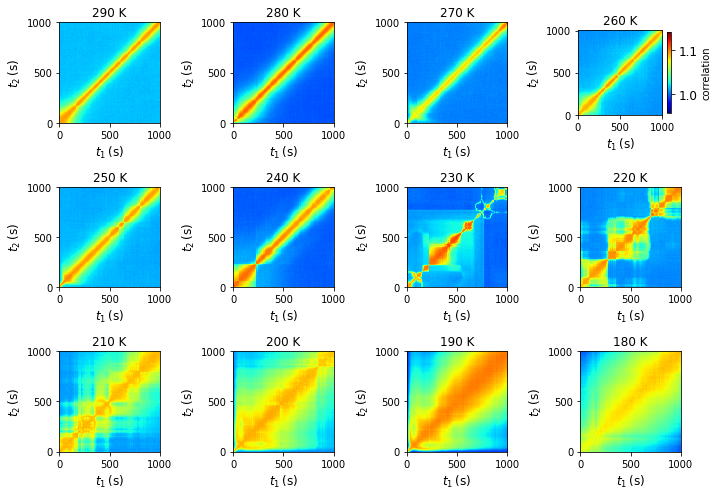

In [29]:
f, axs = plt.subplots(3,4,figsize=(10,7), tight_layout=True)
axs = np.array(axs)
axs = np.ravel(axs) #if condition else np.ravel(axs)

k = np.arange(len(ttcs))

for i, (ind, a) in enumerate(zip(k, axs)):
    im = a.imshow(ttcs[i], origin='lower', cmap='jet', extent=[xy[0], xy[-1]]*2)#, vmin=1, vmax=1.1)
    a.set_title(f'{T[i]} K')
    a.set_xlabel('$t_1\,(\mathrm{s})$', size=12)
    a.set_ylabel('$t_2\,(\mathrm{s})$', size=12)
    a.set_xticks([0,500,1000])
    a.set_yticks([0,500,1000])
    
    if i in [3]:
        cb = plt.colorbar(im, ax=a, shrink=.8, aspect=20, label='correlation')
        cb.ax.tick_params(labelsize=12) 
        
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.6)
#plt.savefig('./01-figures/ttcs.png', dpi=300)
plt.show()

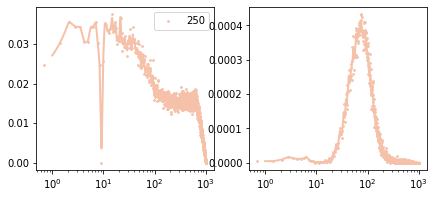

In [30]:
f, (a1,a2) = plt.subplots(1,2,figsize=(7,3))
col = plt.cm.coolwarm_r(np.linspace(0,1,len(ttcs)))
'''
chi_0 = np.asarray(np.var(img3[300:800],axis=0)).squeeze()
plt.plot(chi_0,c='black',alpha=0.3,lw=1)
t_lin = np.linspace(0,len(chi_0),len(chi_0))
t_log = np.logspace(0, 3.1, num=100)
f = interp1d(t_lin, chi_0)
plt.plot(t_log,gaussian_filter(f(t_log),sigma=2),c='red',lw=2)
'''

for i in range(len(ttcs)):
    if i in [4]:
        chi_or = chi4(ttcs[i])
        chi = svd_(ttcs[i])

        t_or = np.linspace(0,1000,len(chi_or))
        t_svd = np.linspace(0,1000,len(chi))

        a1.scatter(t_or, chi_or, c=col[i], s=3, facecolors='none', label=f'{T[i]}')
        a2.scatter(t_svd, chi, c=col[i], s=3, facecolors='none', label=f'{T[i]}')
        
        t_log = np.logspace(0, np.log10(1000), num=1000)        
        f = interp1d(t_or, chi_or)
        a1.plot(t_log, gaussian_filter(f(t_log),sigma=2),c=col[i],lw=2)

        t_log = np.logspace(0, np.log10(1000), num=1000)
        f2 = interp1d(t_svd, chi)
        a2.plot(t_log, gaussian_filter(f2(t_log),sigma=2),c=col[i],lw=2)


a1.set_xscale('log')
a2.set_xscale('log')
a1.legend()
plt.show()

# SVD

### diagonal cuts

In [31]:
ttc = ttcs[4]
#print("ttc:", np.shape(ttc))

#subtract baseline
bl = np.mean(ttc[-100:,:100])
ttc = ttc - bl +1

In [32]:
# rotate image
img = rotate(ttc, angle=-45, reshape=True)
print("img: ", np.shape(img))

# fill in with zeros
img[img==0.]=1.

img:  (2814, 2814)


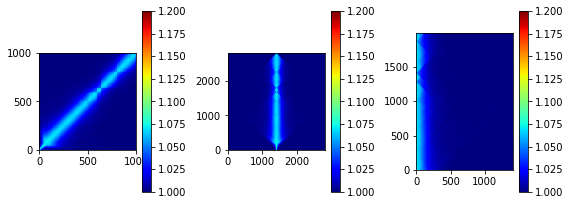

In [33]:
plt.figure(figsize=[8,3])
plt.subplot(1,3,1)
plt.imshow(ttc,origin='lower',cmap='jet',vmin=1,vmax=1.2, extent=[xy[0],xy[-1]]*2)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(img,origin='lower',cmap='jet',vmin=1,vmax=1.2)
plt.colorbar()

plt.subplot(1,3,3)
img2 = img[400:2400,1400:]
#img2 = img[1900:2400,1400:]
y = xy[600:2200]
x = xy[1400:]

plt.imshow(img2,origin='lower',cmap='jet',vmin=1,vmax=1.2)
plt.colorbar()
plt.tight_layout()

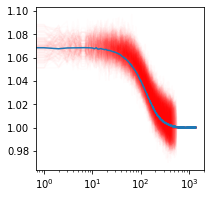

In [34]:
plt.figure(figsize=[3,3])
for i in range(150):
    plt.plot(img2[i],alpha=0.01,c='red')
avg = np.average(np.array(img2),axis=0)
plt.plot(avg)
plt.xscale('log')
plt.show()

In [35]:
# normalise
img3 = (img2-img2.mean())/img2.std()

In [36]:
# Perform SVD using np.linalg.svd
U, s, V = np.linalg.svd(img3) 

In [37]:
# Compute Variance explained by each singular vector
var_explained = np.round(s**2/np.sum(s**2), decimals=3)

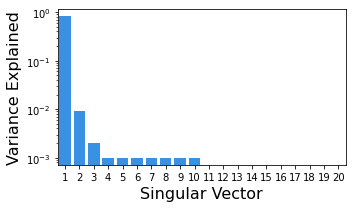

In [38]:
plt.figure(figsize=[5,3])
sns.barplot(x=list(range(1,21)),
            y=var_explained[0:20], color="dodgerblue")
plt.xlabel('Singular Vector', fontsize=16)
plt.ylabel('Variance Explained', fontsize=16)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [39]:
# all components
num = 10
e_ = np.matrix(U[:, :num]) * np.diag(s[:num]) * np.matrix(V[:num, :])

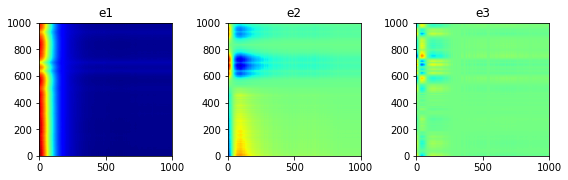

In [40]:
# first component
num = 1
e1 = np.matrix(U[:, :num]) * np.diag(s[:num]) * np.matrix(V[:num, :])

# second component
num = 2
e2 = np.matrix(U[:, :num]) * np.diag(s[:num]) * np.matrix(V[:num, :])
e2 = e2 - e1 

# third component
num = 3
e3 = np.matrix(U[:, :num]) * np.diag(s[:num]) * np.matrix(V[:num, :])
e3 = e3 - e2 - e1 


# plot all three
plt.figure(figsize=[8,3])
plt.subplot(1,3,1)
plt.imshow(e1,origin='lower', extent=[xy[0],xy[-1],xy[0],xy[-1]],cmap='jet')
plt.title("e1")
plt.subplot(1,3,2)
plt.imshow(e2,origin='lower', extent=[xy[0],xy[-1],xy[0],xy[-1]],cmap='jet')
plt.title("e2")
plt.subplot(1,3,3)
plt.imshow(e3,origin='lower', extent=[xy[0],xy[-1],xy[0],xy[-1]],cmap='jet')
plt.title("e3")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'e all')

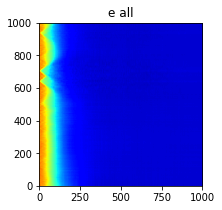

In [41]:
plt.figure(figsize=[8,3])
plt.imshow(e_,origin='lower', extent=[xy[0],xy[-1],xy[0],xy[-1]],cmap='jet')
plt.title("e all")

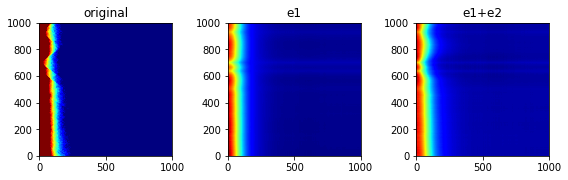

In [42]:
# reconstruct image
plt.figure(figsize=[8,3])
plt.subplot(1,3,1)
plt.imshow(img3,origin='lower', extent=[xy[0],xy[-1],xy[0],xy[-1]],cmap='jet', vmax=1.9, vmin=0)
plt.title("original")
plt.subplot(1,3,2)
plt.imshow(e1,origin='lower', extent=[xy[0],xy[-1],xy[0],xy[-1]],cmap='jet')
plt.title("e1")
plt.subplot(1,3,3)
plt.imshow(e1+e2,origin='lower', extent=[xy[0],xy[-1],xy[0],xy[-1]],cmap='jet')
plt.title("e1+e2")
plt.tight_layout()
plt.show()


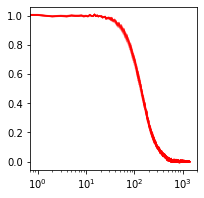

In [43]:
e12 = e1+e2#+e3
e123 = e1+e2+e3
plt.figure(figsize=[3,3])

for i in range(0,450,50):
    g2 = np.array(e12)[i]
    g2 -= g2[-1]
    g2 /= g2[0]
    plt.plot(g2,c='red',alpha=0.4)
    
#for i in range(450,1000,50):
#    g2 = np.array(e_)[i]
#    g2 -= g2[-1]
#    g2 /= g2[0]
#    plt.plot(g2,c='blue',alpha=0.4)
plt.xscale('log')
plt.show()

In [44]:
e12_norm = np.zeros(e12.shape)
e123_norm = np.zeros(e123.shape)
# normalise
for i in range(0,len(e12)):
    e12_norm[i] = np.array(e12)[i]
    e12_norm[i] -= e12_norm[i][-1]
    e12_norm[i] /= e12_norm[i][0]
    
    
    e123_norm[i] = np.array(e_)[i]
    e123_norm[i] -= e123_norm[i][-1]
    e123_norm[i] /= e123_norm[i][0]

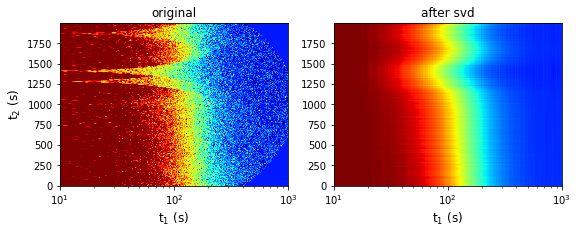

In [45]:
plt.figure(figsize=[9,3])
plt.subplot(1,2,1)
plt.imshow(img3,origin='lower',cmap='jet',vmin=-1,vmax=3., aspect='auto')
plt.xlabel(r't$_1$ (s)',fontsize=12)
plt.ylabel(r't$_2$ (s)',fontsize=12)
#plt.colorbar()
plt.title("original")
plt.xscale('log')
plt.xlim(10,1000)

plt.subplot(1,2,2)
plt.imshow(e12_norm,origin='lower',cmap='jet',vmin=-.2,vmax=1., aspect='auto')
plt.xlabel(r't$_1$ (s)',fontsize=12)
#plt.ylabel(r't$_2$ (s)',fontsize=12)
#plt.title("e1+e2 (norm)")
plt.title("after svd")
plt.xscale('log')
plt.xlim(10,1000)

#plt.savefig('./01-figures/svd-panela.png', dpi=300)
plt.show()

(1414,)


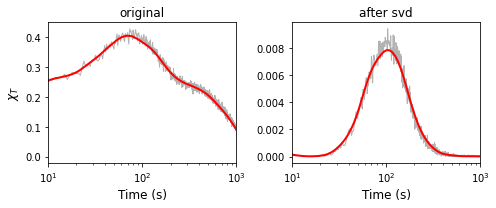

In [46]:
plt.figure(figsize=[7,3])

plt.subplot(1,2,1)
# calculate variance of e2
#chi_0 = np.asarray(np.var(img2[300:800],axis=0)).squeeze()
chi_0 = np.asarray(np.var(img3[:],axis=0)).squeeze()
plt.plot(chi_0,c='black',alpha=0.3,lw=1)
t_lin = np.linspace(0,len(chi_0),len(chi_0))
t_log = np.logspace(0, 3.1, num=100)
f = interp1d(t_lin, chi_0)
plt.plot(t_log,gaussian_filter(f(t_log),sigma=2),c='red',lw=2)

#plt.ylim(-0.001,0.023)
plt.xlim(1e1, 1e3)
plt.xscale('log')
plt.ylabel(r'$\chi_T$',fontsize=12)
plt.xlabel(r'Time (s)',fontsize=12)
plt.title('original')

plt.subplot(1,2,2)
#plt.figure(figsize=[3,3])
# calculate variance of e2
chi = np.asarray(np.var(e12_norm[:],axis=0)).squeeze()
plt.plot(chi,c='black',alpha=0.3,lw=1)
print(chi.shape)

# logarithmic rebinning
t_lin = np.linspace(0,len(chi),len(chi))
t_log = np.logspace(0, 3.1, num=100)
f = interp1d(t_lin, chi)
plt.plot(t_log,gaussian_filter(f(t_log),sigma=2),c='red',lw=2)
#plt.ylim(-0.001,0.005)
plt.xlim(1e1, 1e3)
plt.xscale('log')
plt.xlabel(r'Time (s)',fontsize=12)
#plt.ylabel(r'$\chi_T$')
plt.title('after svd')

plt.tight_layout()
#plt.savefig('./01-figures/svd-panelb.png', dpi=300)
plt.show()

In [47]:
np.array(e12).shape

(2000, 1414)

In [51]:
tmp = d.get_item(inds[2])

In [52]:
tmp.keys()

dict_keys(['corf', 'dcorf', 'trace', 'qv', 'qroi', 'Isaxs', 'mask', 'twotime_corf', 'twotime_par', 'twotime_xy', 'chi4', 'xtwotime_corf', 'xchi4'])

In [53]:
g2_ = tmp['corf'][:,1:]
time = tmp['corf'][:,0]
qv = tmp['qv']

g2.shape, time.shape, qv.shape

((1414,), (71,), (6,))

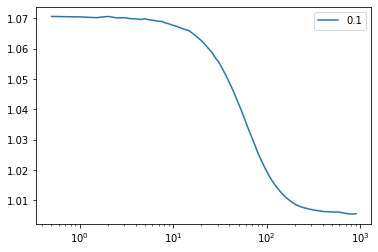

In [56]:
plt.figure()
plt.plot(time[1:], g2_[:,2][1:], label=f'{qv[qvs_sel[2]]}')
plt.xscale('log')
plt.legend()
plt.show()

In [57]:
t_new = np.linspace(0,1000,len(avg))
len(avg)

1414

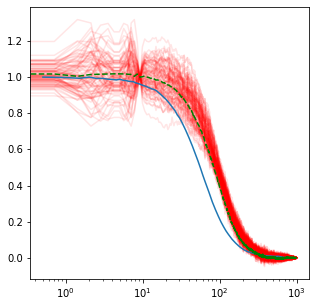

In [59]:
t_new = np.linspace(0,1000,len(avg))

plt.figure(figsize=[5,5])
for i in range(0,900,10):
    g2 = np.array(e123_norm)[i]
    g2 -= g2[-1]
    g2 /= g2[0]
    plt.plot(t_new, g2,c='red',alpha=0.1)

y = g2_[:,2][1:]
plt.plot(time[1:], (y-y[-1])/(y[0]-y[-1]) , label=f'{qv[q_sel]}')

plt.plot(t_new, (avg-avg[-1])/(avg[0]-avg[-1]),ls='--',c='g')

plt.xscale('log')
plt.show()

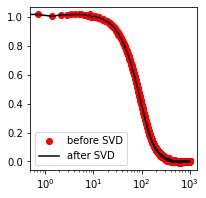

In [60]:
y = np.average(np.array(e12_norm),axis=0)
x = np.arange(0,len(y))
y -=y[-1]
y/=y[0]

#popt,x,curve,perr = fit(exponential,x,y,p0=None,sigma=None,bounds=None)
#print(popt)

plt.figure(figsize=[3,3])
plt.plot(t_new,(avg-avg[-1])/(avg[0]-avg[-1]),'o',label='before SVD', c='red')
plt.plot(t_new,y,ms=3,label='after SVD',ls='-',c='black',)
plt.legend()
#plt.plot(x,curve,c='black',lw=2)
plt.xscale('log')
plt.show()

# For all TTCs

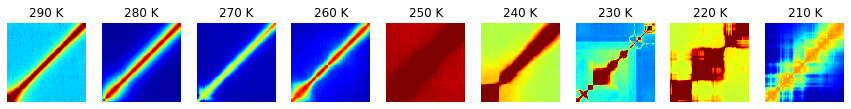

In [101]:
f, axs = plt.subplots(1,9,figsize=(15,3))
col = plt.cm.coolwarm_r(np.linspace(0,1,len(inds)))

for i,ax in enumerate(axs):
    ax.imshow(ttcs[i], origin='lower', vmin=1, vmax=1.1, cmap='jet')
    ax.set_title(f'{T[i]} K')
    ax.axis('off') 
plt.show()

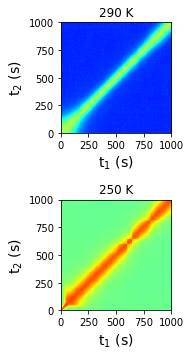

In [62]:
f, (a1,a2) = plt.subplots(2,1,figsize=(3.5,5))

#for i,ax in enumerate(axs):
a1.imshow(ttcs[0], origin='lower', vmin=1, vmax=1.2, cmap='jet', extent=[xy[0],xy[-1]]*2)
a1.set_title(f'{T[0]} K')

a2.imshow(ttcs[4], origin='lower', vmin=1, vmax=1.2, cmap='jet', extent=[xy[0],xy[-1]]*2)
a2.set_title(f'{T[4]} K')

a1.set_xlabel('t$_1$ (s)', fontsize=14)
a1.set_ylabel('t$_2$ (s)', fontsize=14)
a1.set_xticks([0,250,500,750,1000])
a1.set_yticks([0,250,500,750,1000])

a2.set_xlabel('t$_1$ (s)', fontsize=14)
a2.set_ylabel('t$_2$ (s)', fontsize=14)
a2.set_xticks([0,250,500,750,1000])
a2.set_yticks([0,250,500,750,1000])
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.6)
#plt.savefig('./01-figures/fig4-panelc.png', dpi=300)
plt.show()

### first two components selected

**Calculations**

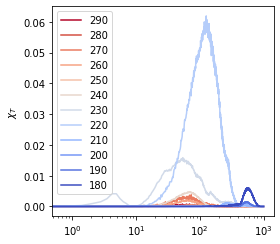

In [63]:
chis = []

plt.figure(figsize=(4,3.5))
col = plt.cm.coolwarm_r(np.linspace(0,1,len(inds)))

for i in range(len(inds)):
    chi = svd_(ttcs[i])
    chis.append(chi)
    
    plt.plot(t_new, chi, c=col[i], label=T[i])

#plt.xlim(1e1, 1e3)
plt.xscale('log')
plt.ylabel(r'$\chi_T$')
plt.legend()
plt.tight_layout()  
plt.show()

In [64]:
chi.shape, t_new.shape

((1414,), (1414,))

**Plots**

0 1414 1414
0 1000 1414
0 1414 1414
0 1000 1414
0 1414 1414
0 1000 1414
0 1414 1414
0 1000 1414


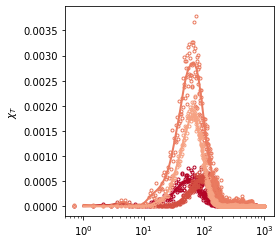

In [65]:
plt.figure(figsize=(4,3.5))
col = plt.cm.coolwarm_r(np.linspace(0,1,len(inds)))

for i,chi in enumerate(chis[:4]):
    
    print(0,len(chi),len(chi))
    print(0,1000,len(chi))
    # logarithmic rebinning
    t_lin = np.linspace(0,1000,len(chi))
    t_log = np.logspace(0, np.log10(1000), num=100)
    f = interp1d(t_lin, chi)
    
    plt.plot(t_lin, chi, c=col[i], ls='', marker='o',ms=3, fillstyle='none')
    plt.plot(t_log, gaussian_filter(f(t_log),sigma=2),c=col[i],lw=2, label=T[i])

plt.xscale('log')
plt.ylabel(r'$\chi_T$')
plt.tight_layout()  
plt.show()

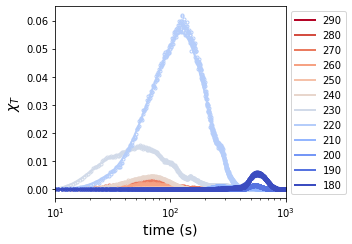

In [88]:
plt.figure(figsize=(5,3.5))
col = plt.cm.coolwarm_r(np.linspace(0,1,len(inds)))

for i,chi in enumerate(chis):
    
    # logarithmic rebinning
    
    t_lin = np.linspace(0,1000,len(chi))
    t_log = np.logspace(0, np.log10(1000), num=100)
    
    f = interp1d(t_lin, chi)
    
    
    #t_lin = np.linspace(0,len(chi),len(chi))
    #t_log = np.logspace(0, 3.1, num=100)
    #f = interp1d(t_lin, chi)
        
#     if i in [4,5,6,7]:
    plt.plot(t_lin, chi, c=col[i], ls='', marker='o',ms=3, fillstyle='none')
    plt.plot(t_log, gaussian_filter(f(t_log),sigma=2),c=col[i],lw=2, label=T[i])

plt.xlim(1e1, 1e3)
plt.xscale('log')
plt.ylabel(r'$\chi_T$', fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.legend(bbox_to_anchor=[1,1])
plt.tight_layout()  
plt.show()

**Plot for paper**

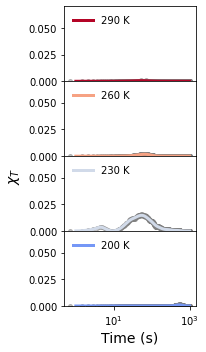

In [102]:
fig = plt.figure(figsize=(3,5),  tight_layout=True)
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
col = plt.cm.coolwarm_r(np.linspace(0,1,len(inds)))
js = [0,3,6,9]

for i,ax in enumerate(axs):
    j = js[i]
    t_lin = np.linspace(0,1000,len(chis[j]))
    t_log = np.logspace(0, np.log10(1000), num=100)
    
    #t_lin = np.linspace(0,len(chis[j]),len(chis[j]))
    #t_log = np.logspace(0, 3.1, num=100)
    f = interp1d(t_lin, chis[j])
    
    ax.plot(t_lin, chis[j], c='gray', ls='', marker='o', ms=4, alpha=.5)
#     if j==4: co = col[j+2]
#     else: co = col[j]
    ax.plot(t_log, gaussian_filter(f(t_log),sigma=2), c=col[j], lw=3, label=f'{T[j]} K')
    #ax.axvline(x=10,ls='--')
    #ax.axvline(x=20,ls='--')
    ax.legend(loc='upper left', frameon=False)
    ax.label_outer()
    ax.set_ylim(0,7e-2)
    #ax.set_xlim(0,10e3)
    ax.set_xscale('log')
    
#     if i==0: ax.set_yticks([0,0.005,0.01,0.015])
#     else: ax.set_yticks([0,0.005,0.01])

fig.supylabel(r'$\chi_T$', x=0.07, y=0.5, fontsize=14)
axs[3].set_xlabel('Time (s)', fontsize=14)
#plt.savefig('./01-figures/fig4-panela.png', dpi=300)
fig.show()

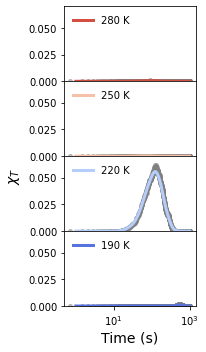

In [104]:
fig = plt.figure(figsize=(3,5),  tight_layout=True)
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
col = plt.cm.coolwarm_r(np.linspace(0,1,len(inds)))
js = [1,4,7,10]

for i,ax in enumerate(axs):
    j = js[i]
    t_lin = np.linspace(0,1000,len(chis[j]))
    t_log = np.logspace(0, np.log10(1000), num=100)
    
    #t_lin = np.linspace(0,len(chis[j]),len(chis[j]))
    #t_log = np.logspace(0, 3.1, num=100)
    f = interp1d(t_lin, chis[j])
    
    ax.plot(t_lin, chis[j], c='gray', ls='', marker='o', ms=4, alpha=.5)
#     if j==4: co = col[j+2]
#     else: co = col[j]
    ax.plot(t_log, gaussian_filter(f(t_log),sigma=2), c=col[j], lw=3, label=f'{T[j]} K')
    #ax.axvline(x=10,ls='--')
    #ax.axvline(x=20,ls='--')
    ax.legend(loc='upper left', frameon=False)
    ax.label_outer()
    ax.set_ylim(0,7e-2)
    #ax.set_xlim(0,10e3)
    ax.set_xscale('log')
    
#     if i==0: ax.set_yticks([0,0.005,0.01,0.015])
#     else: ax.set_yticks([0,0.005,0.01])

fig.supylabel(r'$\chi_T$', x=0.07, y=0.5, fontsize=14)
axs[3].set_xlabel('Time (s)', fontsize=14)
#plt.savefig('./01-figures/fig4-panela.png', dpi=300)
fig.show()

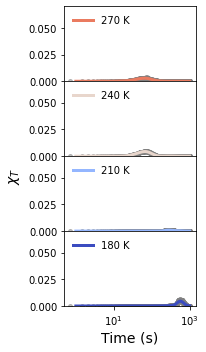

In [105]:
fig = plt.figure(figsize=(3,5),  tight_layout=True)
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
col = plt.cm.coolwarm_r(np.linspace(0,1,len(inds)))
js = [2,5,8,11]

for i,ax in enumerate(axs):
    j = js[i]
    t_lin = np.linspace(0,1000,len(chis[j]))
    t_log = np.logspace(0, np.log10(1000), num=100)
    
    #t_lin = np.linspace(0,len(chis[j]),len(chis[j]))
    #t_log = np.logspace(0, 3.1, num=100)
    f = interp1d(t_lin, chis[j])
    
    ax.plot(t_lin, chis[j], c='gray', ls='', marker='o', ms=4, alpha=.5)
    if j==4: co = col[j+2]
    else: co = col[j]
    ax.plot(t_log, gaussian_filter(f(t_log),sigma=2), c=col[j], lw=3, label=f'{T[j]} K')
    #ax.axvline(x=10,ls='--')
    #ax.axvline(x=20,ls='--')
    ax.legend(loc='upper left', frameon=False)
    ax.label_outer()
    ax.set_ylim(0,7e-2)
    #ax.set_xlim(0,10e3)
    ax.set_xscale('log')
    
#     if i==0: ax.set_yticks([0,0.005,0.01,0.015])
#     else: ax.set_yticks([0,0.005,0.01])

fig.supylabel(r'$\chi_T$', x=0.07, y=0.5, fontsize=14)
axs[3].set_xlabel('Time (s)', fontsize=14)
#plt.savefig('./01-figures/fig4-panela.png', dpi=300)
fig.show()

### Chi4 analysis

In [70]:
from scipy.optimize import curve_fit

In [71]:
def poly2(x,a0,a1,a2):
    return a0 + a1*x + a2*x**2

def poly3(x,a0,a1,a2,a3):
    return a0 + a1*x + a2*x**2 + a3**3

def gaussian(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

Kb = 1 #1.380649e-23 #m2 kg s-2 K-1

def VFT(x,t1,B,T0):
    return t1 * np.exp( B * T0/(x - T0) )
    #return t1 * np.exp( B/(x - T0) )

def arrhenius(x,t1,Ea):
    return t1 * np.exp( Ea/(x*Kb) )

def lorentzian(x, a, x0, sigma):
    return a*sigma**2 / ((x-x0)**2 + sigma**2) 


def voigt(x, ampG1, cenG1, sigmaG1, ampL1, cenL1, widL1):
    return (ampG1*(1/(sigmaG1*(np.sqrt(2*np.pi))))*(np.exp(-((x-cenG1)**2)/((2*sigmaG1)**2)))) +\
              ((ampL1*widL1**2/((x-cenL1)**2+widL1**2)) )

In [72]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

[1.19556906e-01 2.26472052e+02 5.25089615e+00]


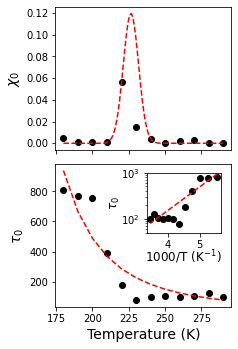

In [84]:
f, (ax1,ax2) = plt.subplots(2,1,figsize=(3.5,5), sharex=True)

chi_max, chi_max_x = [], []
tau = []

for i,chi in enumerate(chis):
    # logarithmic rebinning
    t_lin = np.linspace(0,len(chi),len(chi))
    t_log = np.logspace(0, 3.1, num=100)
    f = interp1d(t_lin, chi)
    
    if i != 6: 
        #print(i, T[i], np.max(gaussian_filter(f(t_log),sigma=2)))
        chi_max.append(np.max(gaussian_filter(f(t_log),sigma=2)))
        chi_max_x.append(float(T[i]))
        
    ax1.plot(T[i], np.max(gaussian_filter(f(t_log),sigma=2)), c='k', ls='', marker='o',ms=6)
    ax2.plot(T[i], t_lin[np.argmax(chis[i])], c='k', ls='', marker='o',ms=6)
    tau.append(t_lin[np.argmax(chis[i])])
#     if i in [4,5]:
#         ax2.plot(T[i], t_lin[np.argmax(chis[i][10:80])], c='k', ls='', marker='o',ms=6, fillstyle='none')
#         ax2.plot(T[i], t_lin[np.argmax(chis[i][:20])], c='k', ls='', marker='s',ms=6, fillstyle='none')
#ax1.scatter(chi_max_x, chi_max, c='k')#, ls='', marker='o',ms=6)

chi_max = np.array(chi_max)
chi_max_x = np.array(chi_max_x)
# popt,xc,curve,perr = fit(poly2, chi_max_x, chi_max, p0=[1,1,1],xc_len=True)
#ax1.plot(xc, curve, ls='--', c='r')

popt,xc,curve,perr = fit(gaussian, chi_max_x, chi_max, p0=[.01,220,20],xc_len=True)
ax1.plot(xc, curve, ls='--', c='r')

# popt,xc,curve,perr = fit(lorentzian, chi_max_x, chi_max, p0=[.01,220,10], xc_len=True)
# ax1.plot(xc, curve, ls='--', c='r')
print(popt)

# popt,xc,curve,perr = fit(voigt, chi_max_x, chi_max, p0=[.005,230,5, .05,230,5],xc_len=True)
# ax1.plot(xc, curve, ls='--', c='b')
#ampG1, cenG1, sigmaG1, ampL1, cenL1, widL1

popt2,xc2,curve2,perr2 = fit(arrhenius, T, tau, p0=[2e-1, 1e3])
ax2.plot(xc2,curve2, c='r', ls='--')

# inset panel A
ax4 = plt.axes([0,0,1,1])
ip = InsetPosition(ax2, [0.52,0.52,0.42,0.42]) #x0,y0, x_length, y_length [0.57,0.57,0.4,0.4]
ax4.set_axes_locator(ip)

ax4.plot(1000/xc2,curve2, c='r', ls='--')
ax4.scatter(1000/T, tau, c='k')

ax4.set_yscale('log')
ax4.set_ylabel(r'$\tau_0$', fontsize=12,labelpad=-1)
ax4.set_xlabel(r'1000/T (K$^{-1}$)', fontsize=12,labelpad=-1)
ax4.set_ylim(50,1e3)

ax1.set_ylabel(r'$\chi_0$', fontsize=14)
ax2.set_ylabel(r'$\tau_0$', fontsize=14)
ax2.set_xlabel('Temperature (K)', fontsize=14)
plt.tight_layout()
#plt.savefig('./01-figures/fig4-panelb.png', dpi=300)
plt.show()

`delta_chi = integrated chi / time max`

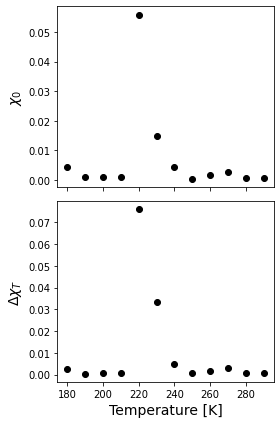

In [75]:
f, (ax1,ax2) = plt.subplots(2,1,figsize=(4,6), sharex=True)

chi_max, chi_max_x = [], []
tau = []

for i,chi in enumerate(chis):
    # logarithmic rebinning
    t_lin = np.linspace(0,len(chi),len(chi))
    t_log = np.logspace(0, 3.1, num=100)
    f = interp1d(t_lin, chi)
    
    ax1.plot(T[i], np.max(gaussian_filter(f(t_log),sigma=2)), c='k', ls='', marker='o',ms=6)
    
    intt = np.trapz(gaussian_filter(f(t_log),sigma=2), x=t_log)
    #ax1.plot(T[i], np.max(gaussian_filter(f(t_log),sigma=2)), c='k', ls='', marker='o',ms=6)
    ax2.plot(T[i],intt/np.argmax(chis[i]), c='k', ls='', marker='o',ms=6)
    
    
ax1.set_ylabel(r'$\chi_0$', fontsize=14)
ax2.set_ylabel(r'$\Delta\chi_T$', fontsize=14)
ax2.set_xlabel('Temperature [K]', fontsize=14)
plt.tight_layout()
#plt.savefig('./01-figures/fig4-panelb.png', dpi=300)
plt.show()